<a href="https://colab.research.google.com/github/denizbariscan/DSA210-Term-Project/blob/main/machine%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
#Read Hiltown Revenue Data
hilltown_revenue_df = pd.read_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx")

#Get the total sales count from file
htfile = "/content/drive/MyDrive/dsa/Hilltown Ürün Çıkış Raporu 8 Ekim - 10 Nisan.xlsx"
ht_df = pd.read_excel(htfile)

#data cleaning
ht_df.columns = ht_df.columns.str.strip()
ht_df["Tutar"] = pd.to_numeric(ht_df["Tutar"], errors="coerce")
ht_df["Adet"] = pd.to_numeric(ht_df["Adet"], errors="coerce")
ht_df = ht_df.dropna(subset=["Tutar", "Adet"])
ht_df = ht_df[ht_df["Tutar"] > 0]

#sum of all sales made until may
total_units_sold_overall = ht_df["Adet"].sum()

#make a feature set for Hiltown
hilltown_df = hilltown_revenue_df.copy()
hilltown_df["Avg_Ciro"] = hilltown_df["Total Revenue"]
hilltown_df["Rainy_Days"] = [4, 6, 9, 8, 8, 7, 6]
hilltown_df["Uni_Tatil"] = [1.5, 5, 0, 11, 0, 1, 4]
hilltown_df["Total_Units_Sold"] = total_units_sold_overall
hilltown_df["Avg_Price"] = hilltown_df["Avg_Ciro"] / hilltown_df["Total_Units_Sold"]
hilltown_df["Avg_Price"] = hilltown_df["Avg_Price"].round(2)

#model features and target
X = hilltown_df[["Avg_Ciro", "Rainy_Days", "Uni_Tatil", "Total_Units_Sold", "Avg_Price"]]
y = hilltown_df["Avg_Ciro"]

# XGBoost model
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X, y)

#prediction for May 2025
may_features = pd.DataFrame([{
    "Avg_Ciro": hilltown_df["Avg_Ciro"].mean(),
    "Rainy_Days": 5,
    "Uni_Tatil": 2,
    "Total_Units_Sold": total_units_sold_overall,
    "Avg_Price": hilltown_df["Avg_Price"].mean().round(2)
}])

#results
may_prediction = model.predict(may_features)[0]
print(f"Predicted Monthly Revenue for May 2025 in Hilltown Branch: ₺{may_prediction:,.2f}")


Predicted Monthly Revenue for May 2025 in Hilltown Branch: ₺3,228,047.00


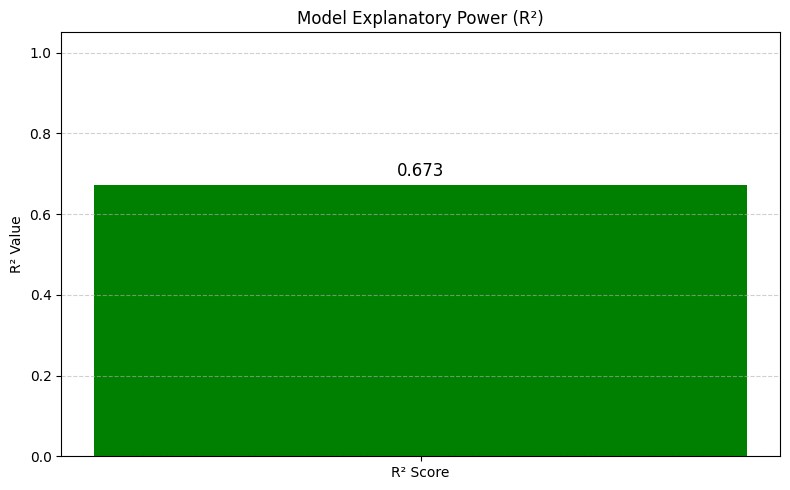

LOOCV MAE: ₺172,582.27
Relative MAE: %5.33
R² Score (full fit): 0.673


In [108]:
#define features (X) and target (Y)
X = hilltown_df[["Avg_Ciro", "Rainy_Days", "Uni_Tatil", "Total_Units_Sold", "Avg_Price"]]
y = hilltown_df["Avg_Ciro"]
#LOOCV
loo = LeaveOneOut()
errors = []
actuals = []
predictions = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test.values[0])
    errors.append(abs(y_pred - y_test.values[0]))

#mean error
mean_loo_mae = sum(errors) / len(errors)
relative_mae = (mean_loo_mae / y.mean()) * 100

#find R^2
model_all = XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1, random_state=42)
model_all.fit(X, y)
y_pred_all = model_all.predict(X)
r2 = r2_score(y, y_pred_all)

#show R² graphically
plt.figure(figsize=(8, 5))
plt.bar(["R² Score"], [r2], color='green')
plt.ylim(0, 1.05)
plt.title("Model Explanatory Power (R²)")
plt.text(0, r2 + 0.02, f"{r2:.3f}", ha='center', fontsize=12)
plt.ylabel("R² Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"LOOCV MAE: ₺{mean_loo_mae:,.2f}")
print(f"Relative MAE: %{relative_mae:.2f}")
print(f"R² Score (full fit): {r2:.3f}")



In [109]:
#Read Balçova Revenue Data
balcova_revenue_df = pd.read_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx")

#get sales data from file
balcovafile = "/content/drive/MyDrive/dsa/urun-cikis-raporu-1744210116 (1).xlsx"
balcova_df = pd.read_excel(balcovafile)

#data cleaning
balcova_df.columns = balcova_df.columns.str.strip()
balcova_df["Tutar"] = pd.to_numeric(balcova_df["Tutar"], errors="coerce")
balcova_df["Adet"] = pd.to_numeric(balcova_df["Adet"], errors="coerce")
balcova_df = balcova_df.dropna(subset=["Tutar", "Adet"])
balcova_df = balcova_df[balcova_df["Tutar"] > 0]

#total sales count until May
total_units_sold_overall = balcova_df["Adet"].sum()

#make a feature set for Balçova
bal_df = balcova_revenue_df.copy()
bal_df["Avg_Ciro"] = bal_df["Total Revenue"]
bal_df["Rainy_Days"] = [4, 6, 9, 8, 8, 7, 6]
bal_df["Uni_Tatil"] = [1.5, 5, 0, 11, 0, 1, 4]
bal_df["Total_Units_Sold"] = total_units_sold_overall
bal_df["Avg_Price"] = bal_df["Avg_Ciro"] / bal_df["Total_Units_Sold"]
bal_df["Avg_Price"] = bal_df["Avg_Price"].round(2)

#define features and target
X = bal_df[["Avg_Ciro", "Rainy_Days", "Uni_Tatil", "Total_Units_Sold", "Avg_Price"]]
y = bal_df["Avg_Ciro"]

#XGBoost
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X, y)

#prediction for May 2025
may_features = pd.DataFrame([{
    "Avg_Ciro": bal_df["Avg_Ciro"].mean(),
    "Rainy_Days": 5,
    "Uni_Tatil": 2,
    "Total_Units_Sold": total_units_sold_overall,
    "Avg_Price": bal_df["Avg_Price"].mean().round(2)
}])

#results
may_prediction = model.predict(may_features)[0]
print(f"Predicted Monthly Revenue for Balçova Branch in May 2025: ₺{may_prediction:,.2f}")

Predicted Monthly Revenue for Balçova Branch in May 2025: ₺1,566,236.50


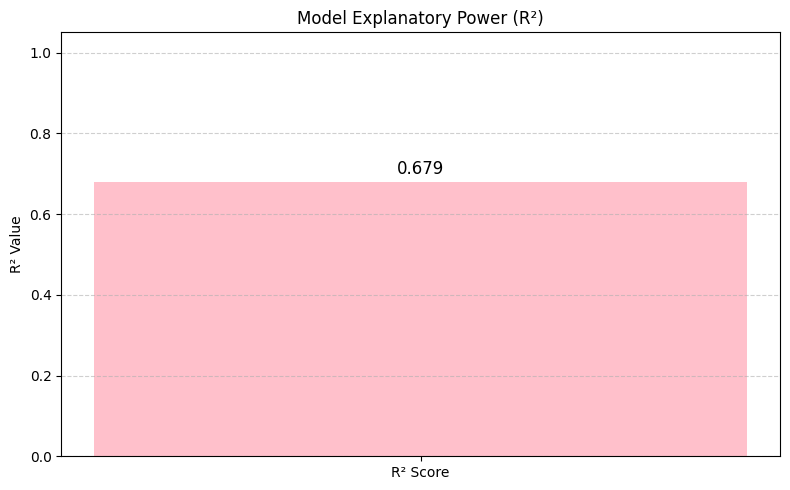

LOOCV MAE: ₺274,304.05
Relative MAE: %17.06
R² Score: 0.679


In [110]:
X = bal_df[["Avg_Ciro", "Rainy_Days", "Uni_Tatil", "Total_Units_Sold", "Avg_Price"]]
y = bal_df["Avg_Ciro"]
#LOOCV
loo = LeaveOneOut()
errors, predictions, actuals = [], [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test.values[0])
    errors.append(abs(y_pred - y_test.values[0]))

#LOOCV results
mean_loo_mae = sum(errors) / len(errors)
relative_mae = (mean_loo_mae / y.mean()) * 100

#calculating R²
model_all = XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1)
model_all.fit(X, y)
r2 = r2_score(y, model_all.predict(X))

#showing R² graphically
plt.figure(figsize=(8, 5))
plt.bar(["R² Score"], [r2], color='pink')
plt.ylim(0, 1.05)
plt.title("Model Explanatory Power (R²)")
plt.text(0, r2 + 0.02, f"{r2:.3f}", ha='center', fontsize=12)
plt.ylabel("R² Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"LOOCV MAE: ₺{mean_loo_mae:,.2f}")
print(f"Relative MAE: %{relative_mae:.2f}")
print(f"R² Score: {r2:.3f}")


Predicted Monthly Revenue for Hilltown Branch in May 2025: ₺3,230,526.25


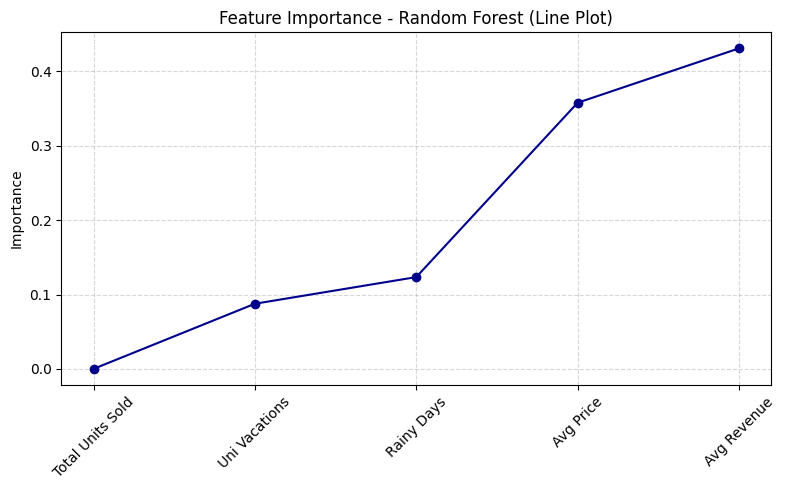

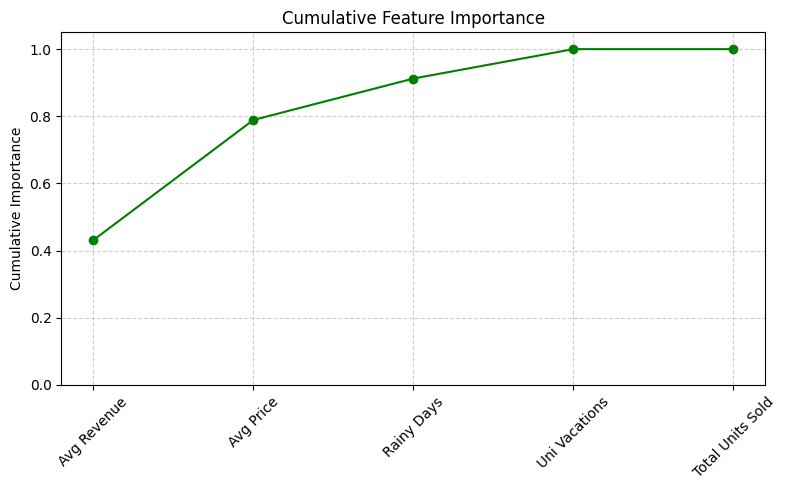

In [120]:
#revenue data
hilltown_df = pd.read_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx")
hilltown_df["Avg_Revenue"] = hilltown_df["Total Revenue"]
hilltown_df["Rainy_Days"] = [4, 6, 9, 8, 8, 7, 6]
hilltown_df["Uni_Vacations"] = [1.5, 5, 0, 11, 0, 1, 4]  # Yeni isim

#sales count data
ht_sales_df = pd.read_excel("/content/drive/MyDrive/dsa/Hilltown Ürün Çıkış Raporu 8 Ekim - 10 Nisan.xlsx")
ht_sales_df["Tutar"] = pd.to_numeric(ht_sales_df["Tutar"], errors="coerce")
ht_sales_df["Adet"] = pd.to_numeric(ht_sales_df["Adet"], errors="coerce")
ht_sales_df = ht_sales_df.dropna(subset=["Tutar", "Adet"])
ht_sales_df = ht_sales_df[ht_sales_df["Tutar"] > 0]
total_units_sold = ht_sales_df["Adet"].sum()

#features
hilltown_df["Total_Units_Sold"] = total_units_sold
hilltown_df["Avg_Price"] = (hilltown_df["Avg_Revenue"] / hilltown_df["Total_Units_Sold"]).round(2)

X = hilltown_df[["Avg_Revenue", "Rainy_Days", "Uni_Vacations", "Total_Units_Sold", "Avg_Price"]]
y = hilltown_df["Avg_Revenue"]

#random forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X, y)

#prediction
may_input = pd.DataFrame([{
    "Avg_Revenue": y.mean(),
    "Rainy_Days": 5,
    "Uni_Vacations": 2,
    "Total_Units_Sold": total_units_sold,
    "Avg_Price": hilltown_df["Avg_Price"].mean()
}])

may_prediction = rf_model.predict(may_input)[0]
print(f"Predicted Monthly Revenue for Hilltown Branch in May 2025: ₺{may_prediction:,.2f}")

#feature importance graphic
importances = rf_model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()
clean_feature_names = [f.replace("_", " ") for f in features]

plt.figure(figsize=(8, 5))
plt.plot(range(len(features)), importances[sorted_idx], marker='o', linestyle='-', color='darkblue')
plt.xticks(range(len(features)), [clean_feature_names[i] for i in sorted_idx], rotation=45)
plt.title("Feature Importance - Random Forest (Line Plot)")
plt.ylabel("Importance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#cumulative feature importance graphic
sorted_idx_rev = importances.argsort()[::-1]
cum_importance = importances[sorted_idx_rev].cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(len(features)), cum_importance, marker='o', color='green')
plt.xticks(range(len(features)), [clean_feature_names[i] for i in sorted_idx_rev], rotation=45)
plt.title("Cumulative Feature Importance")
plt.ylabel("Cumulative Importance")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


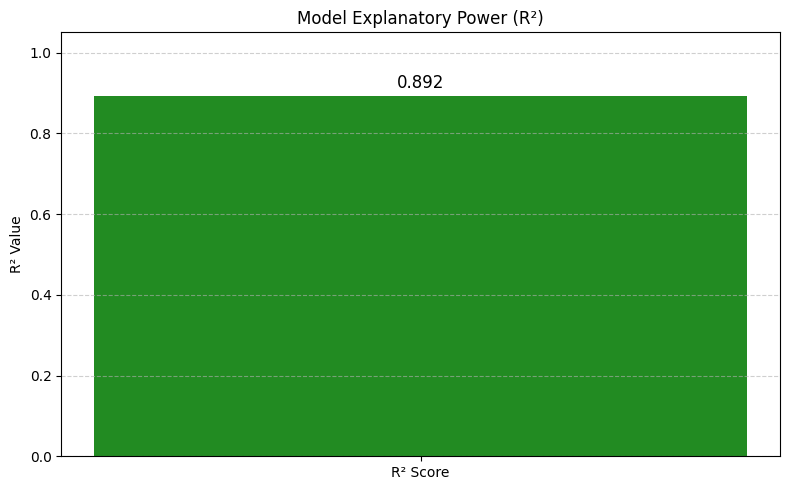

LOOCV MAE: ₺136,321.57
Relative MAE: %4.21
R² Score: 0.892


In [114]:
X = hilltown_df[["Avg_Ciro", "Rainy_Days", "Uni_Vacations", "Total_Units_Sold", "Avg_Price"]]
y = hilltown_df["Avg_Ciro"]
#LOOCV
loo = LeaveOneOut()
errors = []
actuals = []
predictions = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test.values[0])
    errors.append(abs(y_pred - y_test.values[0]))

#MAE and Relative MAE
mean_loo_mae = sum(errors) / len(errors)
relative_mae = (mean_loo_mae / y.mean()) * 100

#calculate R²
rf_model_all = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model_all.fit(X, y)
y_pred_all = rf_model_all.predict(X)
r2 = r2_score(y, y_pred_all)

#show R² graphically
plt.figure(figsize=(8, 5))
plt.bar(["R² Score"], [r2], color='forestgreen')
plt.ylim(0, 1.05)
plt.title("Model Explanatory Power (R²)")
plt.text(0, r2 + 0.02, f"{r2:.3f}", ha='center', fontsize=12)
plt.ylabel("R² Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"LOOCV MAE: ₺{mean_loo_mae:,.2f}")
print(f"Relative MAE: %{relative_mae:.2f}")
print(f"R² Score: {r2:.3f}")


Predicted Monthly Revenue for Balçova Branch in May 2025: ₺1,606,206.85


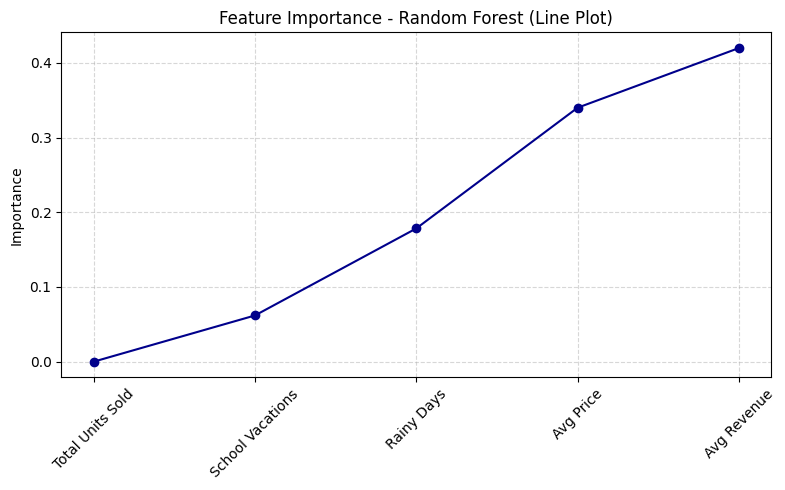

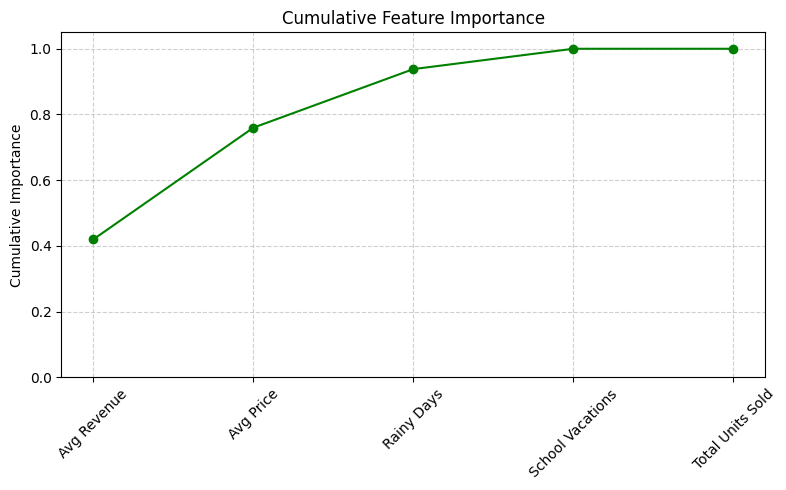

In [122]:
#revenue data
balcova_df = pd.read_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx")
balcova_df["Avg_Revenue"] = balcova_df["Total Revenue"]
balcova_df["Rainy_Days"] = [4, 6, 9, 8, 8, 7, 6]
balcova_df["School_Vacations"] = [1.5, 5, 0, 11, 0, 1, 4]  # Yeni isim

#sales count data
bal_sales_df = pd.read_excel("/content/drive/MyDrive/dsa/urun-cikis-raporu-1744210116 (1).xlsx")
bal_sales_df["Tutar"] = pd.to_numeric(bal_sales_df["Tutar"], errors="coerce")
bal_sales_df["Adet"] = pd.to_numeric(bal_sales_df["Adet"], errors="coerce")
bal_sales_df = bal_sales_df.dropna(subset=["Tutar", "Adet"])
bal_sales_df = bal_sales_df[bal_sales_df["Tutar"] > 0]
total_units_sold = bal_sales_df["Adet"].sum()

#features
balcova_df["Total_Units_Sold"] = total_units_sold
balcova_df["Avg_Price"] = (balcova_df["Avg_Revenue"] / balcova_df["Total_Units_Sold"]).round(2)

X = balcova_df[["Avg_Revenue", "Rainy_Days", "School_Vacations", "Total_Units_Sold", "Avg_Price"]]
y = balcova_df["Avg_Revenue"]

#random forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X, y)

#prediction
may_input = pd.DataFrame([{
    "Avg_Revenue": y.mean(),
    "Rainy_Days": 5,
    "School_Vacations": 2,
    "Total_Units_Sold": total_units_sold,
    "Avg_Price": balcova_df["Avg_Price"].mean()
}])

may_prediction = rf_model.predict(may_input)[0]
print(f"Predicted Monthly Revenue for Balçova Branch in May 2025: ₺{may_prediction:,.2f}")

#feature importance graphic
importances = rf_model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()
clean_feature_names = [f.replace("_", " ") for f in features]

plt.figure(figsize=(8, 5))
plt.plot(range(len(features)), importances[sorted_idx], marker='o', linestyle='-', color='darkblue')
plt.xticks(range(len(features)), [clean_feature_names[i] for i in sorted_idx], rotation=45)
plt.title("Feature Importance - Random Forest (Line Plot)")
plt.ylabel("Importance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#cumulative feature importance graphic
sorted_idx_rev = importances.argsort()[::-1]
cum_importance = importances[sorted_idx_rev].cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(len(features)), cum_importance, marker='o', color='green')
plt.xticks(range(len(features)), [clean_feature_names[i] for i in sorted_idx_rev], rotation=45)
plt.title("Cumulative Feature Importance")
plt.ylabel("Cumulative Importance")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


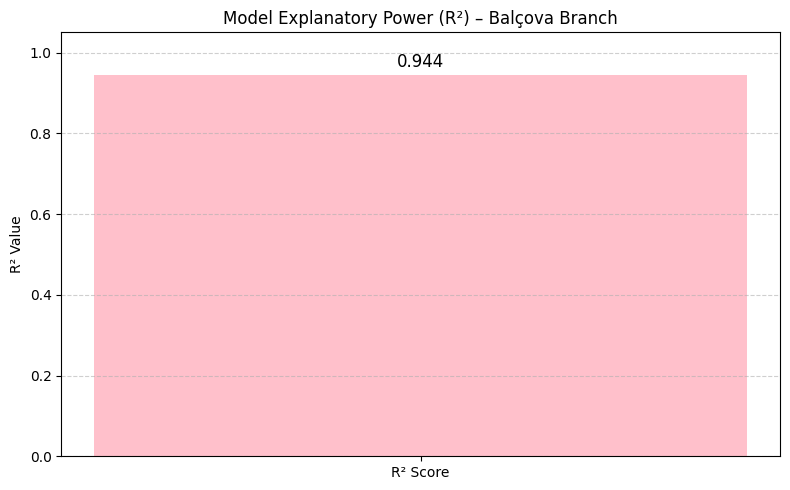

LOOCV MAE: ₺244,060.38
Relative MAE: %15.18
R² Score: 0.944


In [116]:
X = balcova_df[["Avg_Ciro", "Rainy_Days", "Uni_Vacations", "Total_Units_Sold", "Avg_Price"]]
y = balcova_df["Avg_Ciro"]

#LOOCV
loo = LeaveOneOut()
errors = []
actuals = []
predictions = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test.values[0])
    errors.append(abs(y_pred - y_test.values[0]))

#mean error and relative MAE
mean_loo_mae = sum(errors) / len(errors)
relative_mae = (mean_loo_mae / y.mean()) * 100

#calculating R²
model_all = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_all.fit(X, y)
y_pred_all = model_all.predict(X)
r2 = r2_score(y, y_pred_all)

#showing R² graphically
plt.figure(figsize=(8, 5))
plt.bar(["R² Score"], [r2], color='pink')
plt.ylim(0, 1.05)
plt.title("Model Explanatory Power (R²) – Balçova Branch")
plt.text(0, r2 + 0.02, f"{r2:.3f}", ha='center', fontsize=12)
plt.ylabel("R² Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"LOOCV MAE: ₺{mean_loo_mae:,.2f}")
print(f"Relative MAE: %{relative_mae:.2f}")
print(f"R² Score: {r2:.3f}")
